In [36]:
import numpy as np
import mujoco as mj
from robot_descriptions.loaders.mujoco import load_robot_description

import mediapy as media

In [37]:
def render(model, data=None, cam=-1, height=300, option=None):
  if data is None:
    data = mj.MjData(model)
  with mj.Renderer(model, 480, 640) as renderer:
    mj.mj_forward(model, data)
    renderer.update_scene(data, cam, scene_option=option)
    media.show_image(renderer.render(), height=height)

def animate(model, data, duration=3, framerate=60, height=300, cam_pan=False, cam_distance=1, option=None):
  if data is None:
    data = mj.MjData(model)
  
  if cam_pan:
     cam = mj.MjvCamera()
     mj.mjv_defaultCamera(cam)
     cam.lookat = [0, 0, 0]
     cam.distance = cam_distance
     cam.elevation = -30
  else:
     cam = -1
  
  # Simulate and display video
  frames = []
  mj.mj_resetData(model, data) # reset state and time.
  with mj.Renderer(model, 480, 640) as renderer:
      while data.time < duration:
          mj.mj_step(model, data)
          if len(frames) < data.time * framerate: # 仿真步长远小于渲染帧间隔
              if cam_pan:
                 cam.azimuth = 20 + 20 * (1 - np.cos(np.pi*data.time / duration))
              renderer.update_scene(data, cam, scene_option=option)
              pixels = renderer.render()
              frames.append(pixels)
  media.show_video(frames, fps=framerate, height=height)

## Load and render robot arm

MuJoCo 提供了一些常见的机器人模型, 包括机械臂, 末端执行器, 移动机器人平台, 机器狗和机器人. 这些在 [Menagerie](https://github.com/google-deepmind/mujoco_menagerie/tree/main?tab=readme-ov-file#menagerie-models) 里都有对应的 XML 文档可以查看学习.

要加载指定的机器人到 MuJoCo 里有如下两种方法:
- `git clone` Menagerie 仓库到指定目录, 用 `mj.MjModel.from_xml_path` 加载. 每个 Menagerie 文档都包含: 机器人单独建模文件 `robot.xml` 和完整的场景建模 `scene.xml`
- `robot_descriptions` 第三方包, 该包可以为不同仿真器提供一些常见的机器人描述文件 (URDF 或 MJCF). 对于 MuJoCo, 我们需要使用 `robot_descriptions.loaders.mujoco` 下的 `load_robot_description` 函数. 可选的机器人描述在此[表单](https://github.com/robot-descriptions/robot_descriptions.py?tab=readme-ov-file#descriptions), 需要注意的是机器人描述*只*包含机器人本身

""

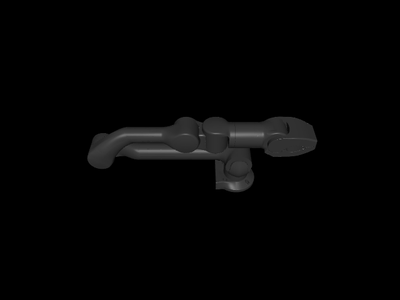

In [38]:
model = mj.MjModel.from_xml_path('../mujoco_menagerie/unitree_z1/z1_gripper.xml')
render(model)

""

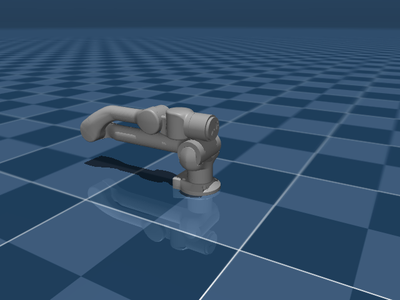

In [39]:
model = mj.MjModel.from_xml_path('../mujoco_menagerie/unitree_z1/scene.xml')
render(model)

""

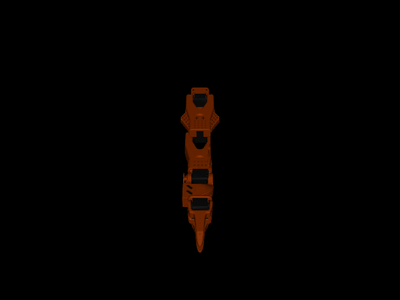

In [40]:
model = load_robot_description('so_arm100_mj_description') # 确保使用 MJCF 而非 URDF
render(model)

### GalaXea A1 arm

Menagerie 的目录本身也是很好的学习资料, 我们也模仿着将 GalaXea A1 机械臂加入进来.

1. 从 GalaXea 的仓库里下载机械臂的 [URDF 和 mesh 文件](https://github.com/userguide-galaxea/URDF.git)
2. 在 `galaxea_a1` 目录下新建一个 `assets` 目录, 将下载的 STL meshes 移动至该目录下
3. 将下载的 URDF 文件移动到 `galaxea_a1` 目录下, 并修改 URDF 文件, 在 `<robot>` 标签下添加 `<mujoco><compiler meshdir="assets/" balanceinertia="false" discardvisual="false" fusestatic="false"/></mujoco>`
4. 在 `galaxea_a1` 目录下打开一个终端, 并输入 `python -m mujoco.viewer` 打开 MuJoCo 仿真可视化工具, 然后将修改过的 URDF 文件拖拽到窗口
5. 没有问题的话, 就能看到 A1 机械臂了, 然后点击左侧控制栏的 `save xml` 保存 MJCF 文件到当前目录
6. 重命名 MJCF 文件为 `a1.xml`
7. 修改 `a1.xml` 文件, 添加 `<actuator>`, 设置碰撞检测 `<contact>` 等内容
8. 新建 `scene.xml` 文件, 创建一个简单的机械臂场景

上面的第2,3步骤将 URDF 文件转换至 MJCF 文件, 我们通过 MuJoCo 自带支持来实现, *URDF 只作为建模仿真里的一小部分*, 我们仍需在 MJCF 里添加更多元素和设置来完成最终的场景搭建.

""

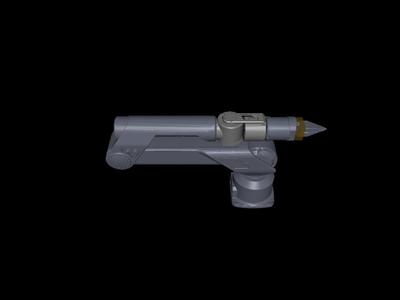

In [41]:
model = mj.MjModel.from_xml_path('galaxea_a1/a1.xml')
render(model)

""

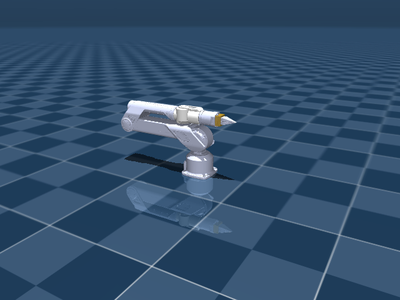

In [42]:
model = mj.MjModel.from_xml_path('galaxea_a1/scene.xml')
render(model)

## Modify the scene via `MjSpec`

下面我们尝试给机械臂场景添加一些物件. 在 MuJoCo 里我们有两种方式实现这一目标:
- 直接编辑 MJCF
- 在 Python 里用 `MjSpec` 来实现

对于一些简单的场景, 直接写 MJCF 可能更方便, 而 `MjSpec` 更灵活, 能交互式地建模. 一些 `MjSpec` 用例可以看官方给的[教程](https://colab.research.google.com/github/google-deepmind/mujoco/blob/main/python/mjspec.ipynb#scrollTo=702z1GBRprxq). 一般来说, `MjSpec` 的语法和 MJCF 里的标签和属性是一致的, 不需要额外记忆.

In [43]:
def get_body_tree(parent, L=None):
    if L is None: L = []
    # 先深度
    body = parent.first_body()
    while body:
        L.append(body.name)
        get_body_tree(body, L)
        # 再广度
        body = parent.next_body(body)
    return L

def print_body_tree(parent, level=0):
    if level == 0:
        print('parent', parent.name, 'has a subtree:')
    body = parent.first_body()
    while body:
        print(''.join(['-' for i in range(level)]) + body.name)
        print_body_tree(body, level + 1)
        body = parent.next_body(body)

def print_list(L, name: str):
    print(f'{name} list contains ({len(L)}):')
    for x in L:
        print(x.name)

def add_object(parent, pos, type, size, euler=[0,0,0], name="", **kwargs):
    TYPE = {'box': mj.mjtGeom.mjGEOM_BOX,
            'sphere': mj.mjtGeom.mjGEOM_SPHERE,
            'cylinder': mj.mjtGeom.mjGEOM_CYLINDER}
    type = TYPE.get(type, 'shpere')
    body = parent.add_body(pos=pos, euler=euler, name=name)
    body.add_geom(type=type, size=size, rgba=np.random.rand(3).tolist()+[1],
                  **kwargs)
    body.add_freejoint()

In [44]:
scene_spec = mj.MjSpec.from_file("galaxea_a1/scene.xml")

### Inspect spec

实例化的 `MjSpec` 只是原 MJCF 的文本解析 (only parsing), 其没有产生新的内容. `MjSpec` 提供了一些 lists 来方便检查里面的内容, 例如:
- `bodies`
- `actuators`
- `joints`
- `cameras`
- ...

In [45]:
print_list(scene_spec.bodies, 'bodies')
print_list(scene_spec.actuators, 'actuators')
print_list(scene_spec.cameras, 'cameras')


bodies list contains (10):
world
base_link
arm_seg1
arm_seg2
arm_seg3
arm_seg4
arm_seg5
arm_seg6
gripper1
gripper2
actuators list contains (8):
shoulder_rot
shoulder_up
elbow
wrist_rot
wrist_swing
gripper_rot
gripper1
gripper2
cameras list contains (0):


想要遍历 kinematic tree (body tree) 的话, 使用 `first_body` 和 `next_body` 来实现:
- `parent.first_body()` - 返回 `parent` 的第一个子节点, *深度上遍历*
- `parent.next_body(body1)` - 返回 `body1` 的下一个兄弟节点, 这些节点有相同的 `parent`, *广度上的遍历*

In [46]:
print_body_tree(scene_spec.worldbody)

parent world has a subtree:
base_link
-arm_seg1
--arm_seg2
---arm_seg3
----arm_seg4
-----arm_seg5
------arm_seg6
-------gripper1
-------gripper2


In [47]:
get_body_tree(scene_spec.worldbody)

['base_link',
 'arm_seg1',
 'arm_seg2',
 'arm_seg3',
 'arm_seg4',
 'arm_seg5',
 'arm_seg6',
 'gripper1',
 'gripper2']

### Add objects

现在给场景添加一些简单的几何体.

In [48]:
for x in np.linspace(-1, 1, 10):
    for y in np.linspace(-1, 1, 10):
        add_object(scene_spec.worldbody, [x,y,0.1], 'sphere', [0.02, 0.02, 0.02])

""

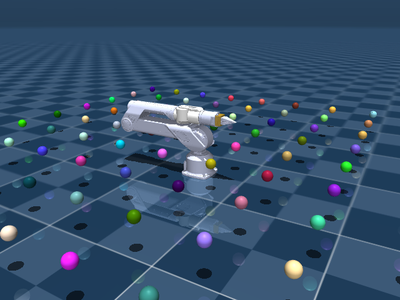

In [49]:
model = scene_spec.compile()
render(model)

In [50]:
animate(model, None, duration=2, cam_pan=True)

### Table scene

最后我们为场景添加一张桌子, 一些物块, 并把机械臂移动到桌子上来.

In [51]:
scene_spec = mj.MjSpec.from_file("galaxea_a1/scene.xml")

>[!Tip] MuJoCo 使用 CCD (凸碰撞检测) 寻找两个物体间的那个接触点 (*convex geom pair has only one contact point*), 对于平滑表面的物体, 例如圆柱体和桌面, CCD 给出的单个接触点不能很好反应真实接触情况, **容易造成仿真不稳定, 表现为sliding 和 wobbling**. 为此, 可以开启 `multiccd` 多点 CCD 检测.

In [52]:
scene_spec.option.enableflags = mj.mjtEnableBit.mjENBL_MULTICCD

In [53]:
scene_spec.stat.extent = 1
scene_spec.visual.quality.shadowsize=4096*2 # higher shadow quality

In [54]:
scene_spec.add_texture(type=mj.mjtTexture.mjTEXTURE_2D, name="wood_tex", file="assets/wood.png")
scene_spec.add_material(name="wood", textures=["wood_tex"]*2)
table = scene_spec.worldbody.add_body(name='table', pos=[0.5,0,0.2])
table.add_geom(type=mj.mjtGeom.mjGEOM_BOX,size=[0.5,0.5,0.01], material="wood")
table_pos = table.pos
add_object(scene_spec.worldbody, table_pos+[0,0,0.1], 'cylinder', [0.02,0.03,0.03], name="bin", mass=0.05)
add_object(scene_spec.worldbody, table_pos+[0.1,0.1,0.1], 'box', [0.02,0.02,0.02], name="box", mass=0.05)

arm_base = scene_spec.body('base_link')
arm_base.pos = table_pos + [-0.4,0,0.01]

再尝试添加几个相机机位: table 和 wrist camera.

In [55]:
table.add_camera(name='table_cam', mode=mj.mjtCamLight.mjCAMLIGHT_TARGETBODY,
                 targetbody='table', pos=[-0.7,-0.7,0.2])
wrist = scene_spec.body('arm_seg6')
wrist.add_camera(name='wrist_cam', mode=mj.mjtCamLight.mjCAMLIGHT_FIXED,
                 pos=[0.05,0,0], xyaxes=[0,1,0,0.7,0,0.3])

In [56]:
[c.name for c in scene_spec.cameras]

['wrist_cam', 'table_cam']

""

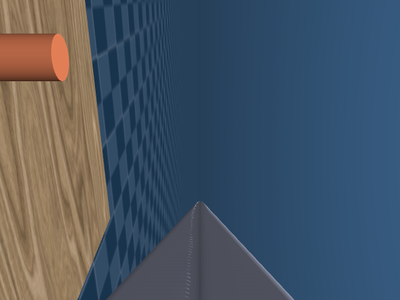

""

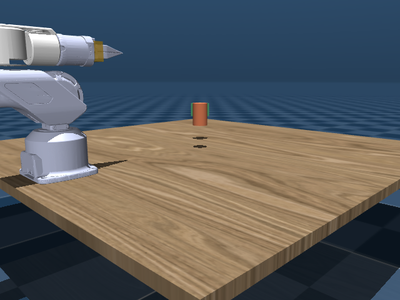

In [57]:
model = scene_spec.compile()
render(model, cam=0)
render(model, cam=1)

In [58]:
animate(model, None, duration=2, cam_pan=True, cam_distance=1.5)

In [59]:
scene_spec.modelname = 'table_scene'
scene_spec.to_file('galaxea_a1/table_scene.xml')

In [60]:
print_list(scene_spec.bodies, 'scene bodies')

scene bodies list contains (13):
world
base_link
table
bin
box
arm_seg1
arm_seg2
arm_seg3
arm_seg4
arm_seg5
arm_seg6
gripper1
gripper2


### Table scene0

上述场景被保存为 MJCF 后包含了机械臂 (robot), 任务相关对象 (task) 和场地 (arena). 这不符合模块化的需求. 一种推荐的做法是将场地, 任务和机器人都单独保存 MJCF.
- `scene0.xml` - 单单场地和灯光
- `table_scene0.xml` - 场地和任务
- `table_scene.xml` - 场地, 任务和机器人

>[! Tip]: 我们可以用 `spec.detach_body(body)` 来从 worldbody 中移除 body. 不知道为什么会报错, 试过✅先 detach body 再添加/修改没问题. 不过还是建议使用如上递进的文件描述, 因为 `<include>` 会包含除了 body 以外的东西, 单单移除 body 还不够, 还要处理 assets, actuator 等等.

In [61]:
scene_spec = mj.MjSpec.from_file("galaxea_a1/scene0.xml")
scene_spec.option.enableflags = mj.mjtEnableBit.mjENBL_MULTICCD
scene_spec.stat.extent = 1
scene_spec.visual.quality.shadowsize=4096*2 # higher shadow quality
print_list(scene_spec.bodies, 'scene bodies')

scene bodies list contains (1):
world


In [62]:
scene_spec.add_texture(type=mj.mjtTexture.mjTEXTURE_2D, name="wood_tex", file="assets/wood.png")
scene_spec.add_material(name="wood", textures=["wood_tex"]*2)
table = scene_spec.worldbody.add_body(name='table', pos=[0.5,0,0.2])
table.add_geom(type=mj.mjtGeom.mjGEOM_BOX,size=[0.5,0.5,0.01], material="wood")
table_pos = table.pos
add_object(scene_spec.worldbody, table_pos+[0,0,0.01+0.1], 'cylinder', [0.02,0.03,0], name="bin", mass=0.05)
add_object(scene_spec.worldbody, table_pos+[0.1,0.1,0.01+0.1], 'box', [0.02,0.02,0.02], name="box", mass=0.05)

table.add_camera(name='table_cam', mode=mj.mjtCamLight.mjCAMLIGHT_TARGETBODY,
                 targetbody='table', pos=[-0.7,-0.7,0.2])

scene_spec.worldbody.add_site(name='robot', pos=table_pos+[-0.4,0,0.01], rgba=[0,0,1,1])

""

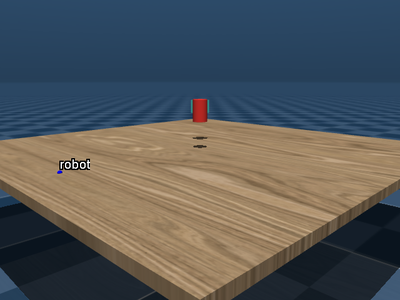

In [63]:
model = scene_spec.compile()

option = mj.MjvOption()
option.label = mj.mjtLabel.mjLABEL_SITE

render(model, cam=0, option=option)

In [64]:
scene_spec.modelname = 'table_scene0'
scene_spec.to_file('galaxea_a1/table_scene0.xml')

### Unitree Z1 arm

我们将 `table_scene0.xml` 拷贝至 `unitree_z1` 目录下, 把 A1 机械臂替换成 Z1 机械臂.

In [65]:
scene_spec = mj.MjSpec.from_file('unitree_z1/table_scene0.xml')
arm_spec = mj.MjSpec.from_file('unitree_z1/z1_gripper.xml')

print_body_tree(arm_spec.worldbody)

parent world has a subtree:
link00
-link01
--link02
---link03
----link04
-----link05
------link06
-------gripperMover


In [66]:
scene_spec.meshdir = arm_spec.meshdir
scene_spec.option.integrator = mj.mjtIntegrator.mjINT_IMPLICITFAST
scene_spec.option.enableflags = mj.mjtEnableBit.mjENBL_MULTICCD
scene_spec.stat.extent = 1
scene_spec.visual.quality.shadowsize=4096*2

In [67]:
arm = arm_spec.body('link00')
robot_site = scene_spec.site('robot')
robot_site.attach_body(arm, 'z1_')

In [68]:
wrist = scene_spec.body('z1_link06')
wrist.add_camera(name='wrist_cam', mode=mj.mjtCamLight.mjCAMLIGHT_FIXED,
                 pos=[0.1,0.08,0.02], xyaxes=[0,0,1,0.3,0.7,0])

""

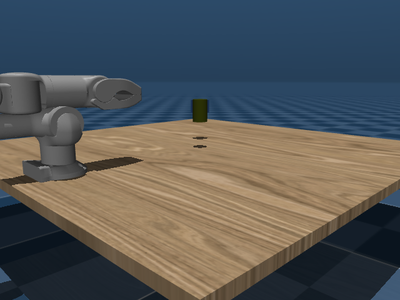

""

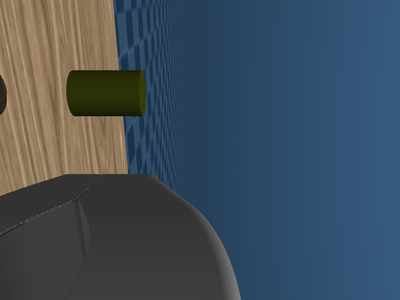

In [69]:
model = scene_spec.compile()
render(model, cam=0)
render(model, cam=1)

In [70]:
scene_spec.modelname = 'table_scene'
scene_spec.to_file('unitree_z1/table_scene.xml')